In [9]:
import sys
sys.path.append('../../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scienceplots
from tensorflow.python.client import device_lib

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *

import re

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '300'})

#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [10]:
model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [11]:
k = 10 # Top 10% highest l2-magnitude filters

In [12]:
def mean_direction(angles, r):
    angles = (angles)
    n = angles.shape[0]
    print(n)

    C = np.sum(r*np.cos(angles))
    S = np.sum(r*np.sin(angles))
    return C,S
    #return C,S
    print(C,S)
    if S > 0 and C > 0:
        return (np.arctan2(S,C))
    if C < 0:
        return (np.arctan2(S,C) + np.pi )
    if S<0 and C > 0:
        print(1)
        return (np.arctan2(S,C) + 2*np.pi)


 ============ LAYER 0 ==================
(3, 3, 64, 10)
 ============ LAYER 1 ==================
(3, 3, 64, 10)
 ============ LAYER 2 ==================
(3, 3, 64, 10)
 ============ LAYER 3 ==================
(3, 3, 128, 10)
 ============ LAYER 4 ==================
(3, 3, 128, 10)
 ============ LAYER 5 ==================
(3, 3, 128, 10)
 ============ LAYER 6 ==================
(3, 3, 128, 10)
 ============ LAYER 7 ==================
(3, 3, 256, 10)
 ============ LAYER 8 ==================
(3, 3, 256, 10)
 ============ LAYER 9 ==================
(3, 3, 256, 10)
 ============ LAYER 10 ==================
(3, 3, 256, 10)
 ============ LAYER 11 ==================
(3, 3, 256, 10)
 ============ LAYER 12 ==================
(3, 3, 256, 10)
 ============ LAYER 13 ==================
(3, 3, 512, 10)
 ============ LAYER 14 ==================
(3, 3, 512, 10)
 ============ LAYER 15 ==================
(3, 3, 512, 10)


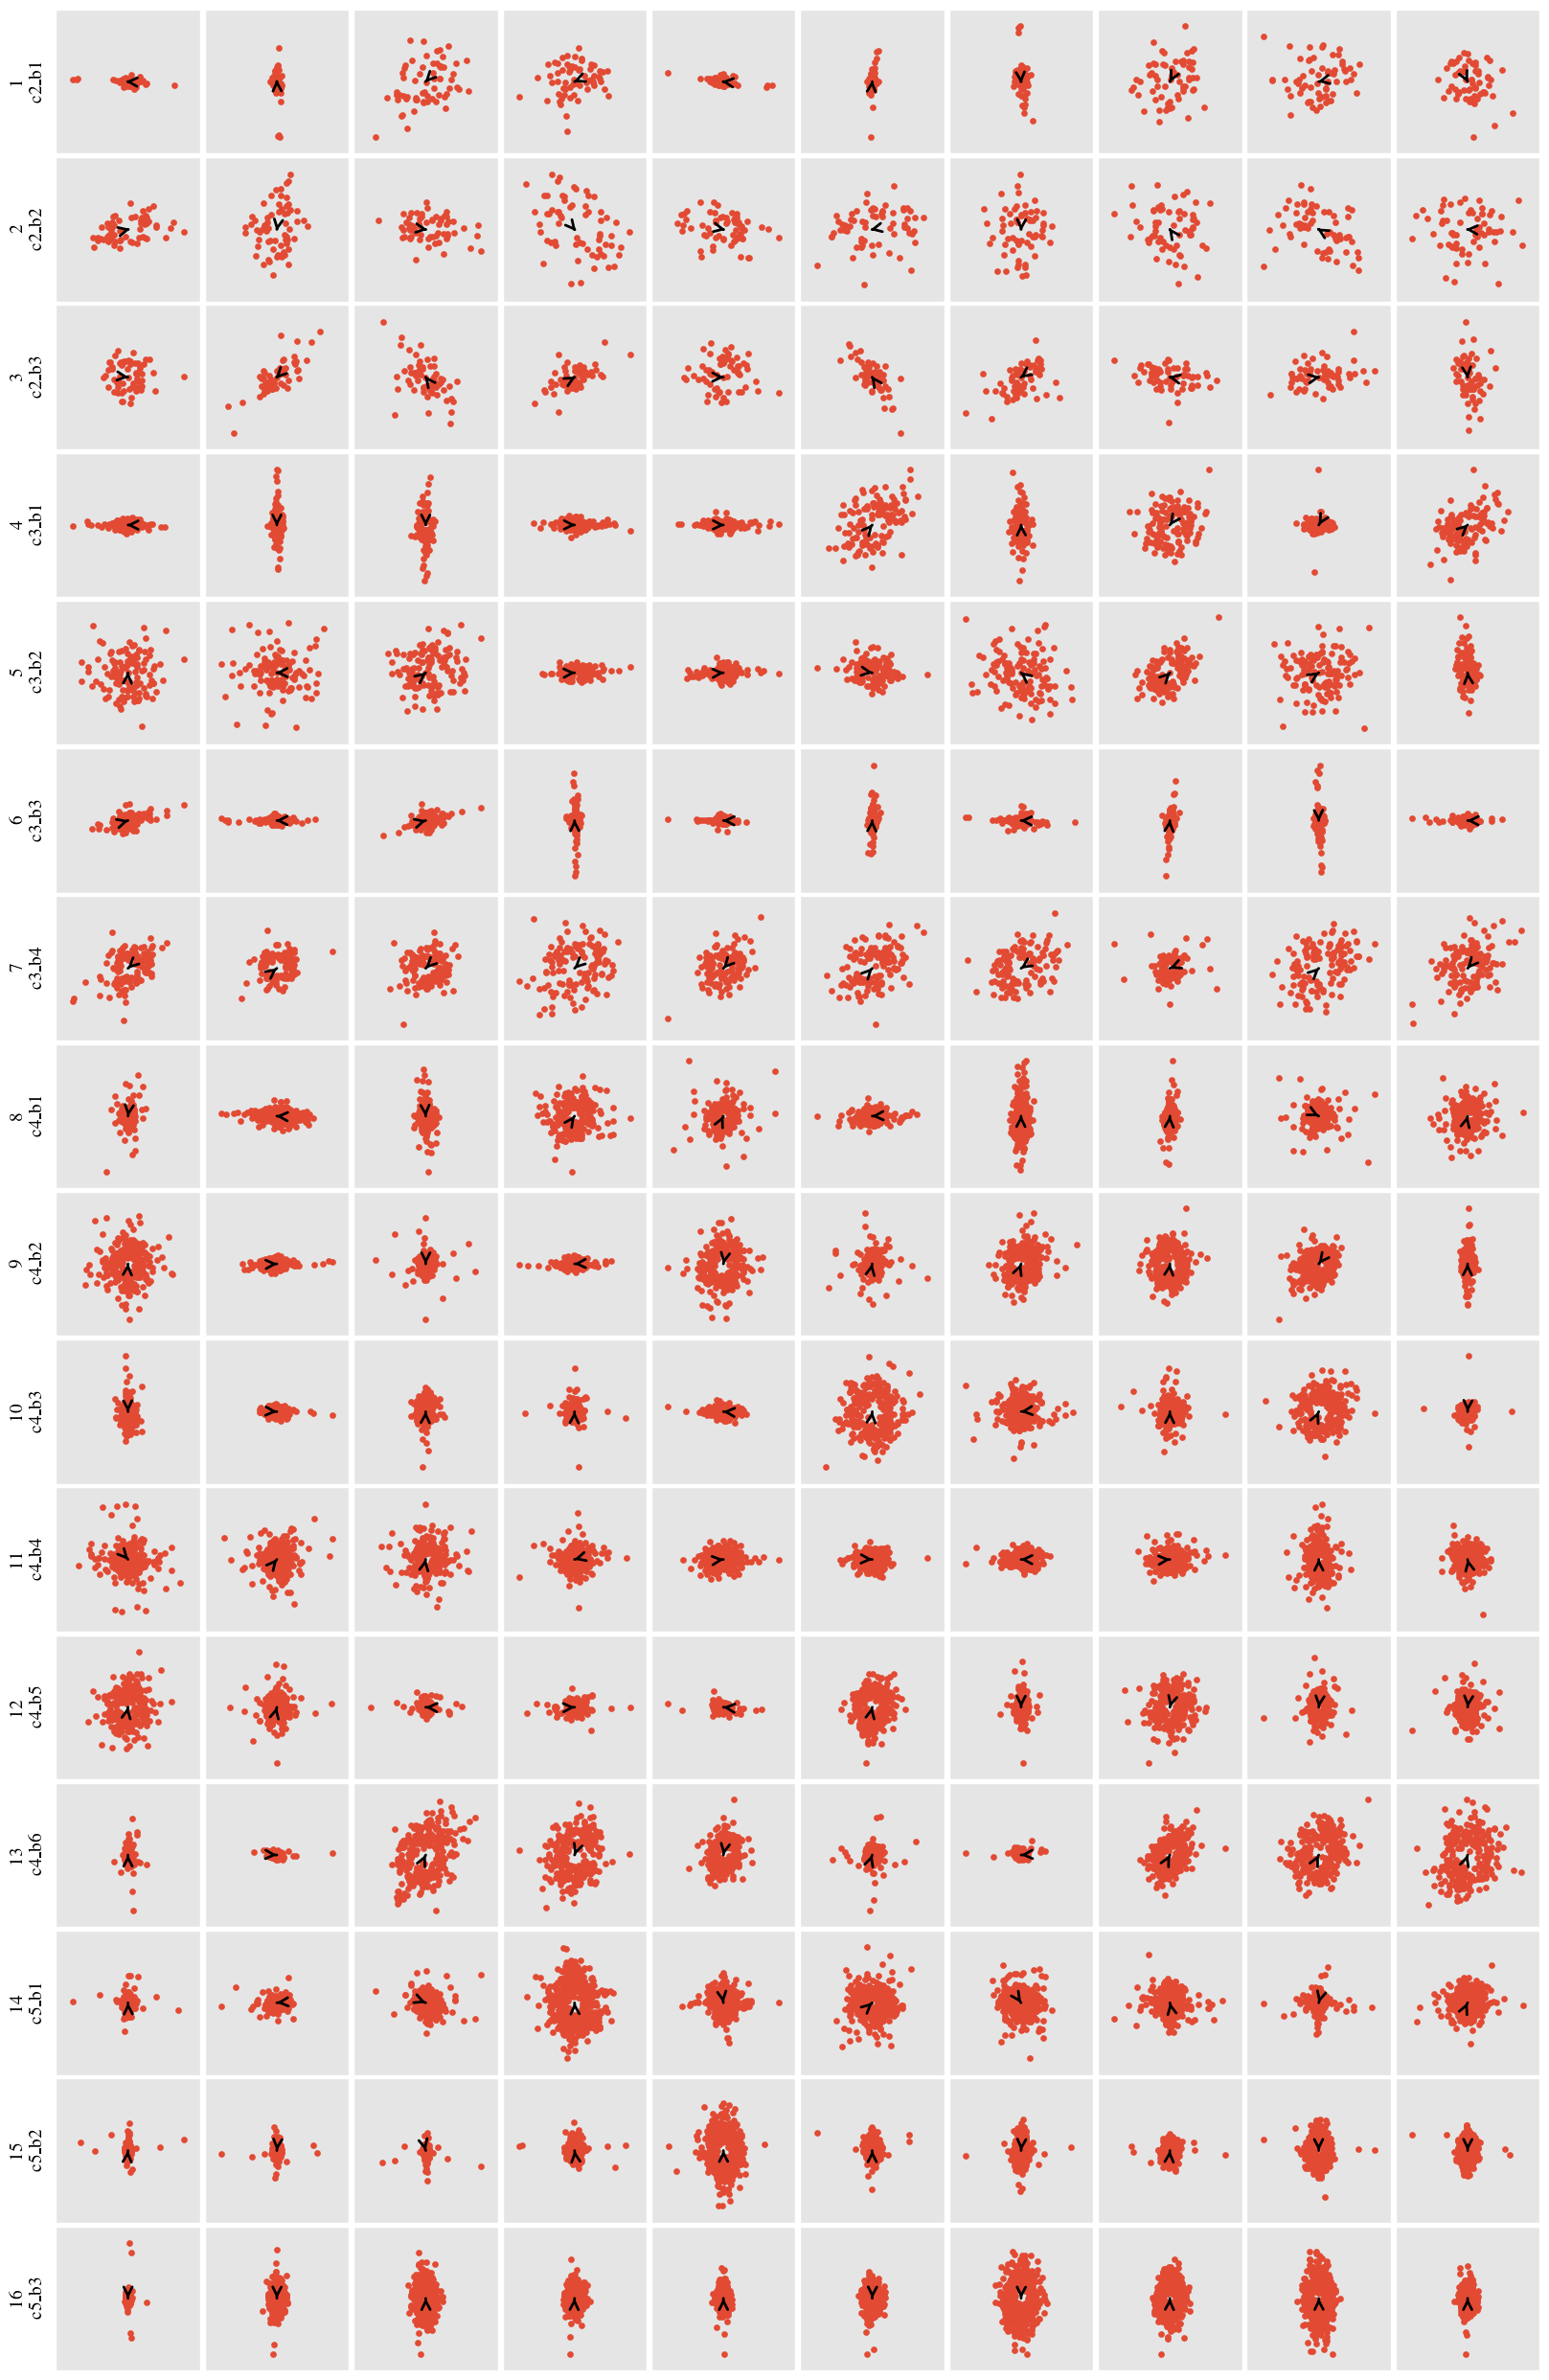

In [13]:

#plt.style.use(['ggplot'])
plt.rcParams.update({'figure.dpi': '200'})
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        if l.kernel_size == (3,3):
            conv_layers.append(l)
e_beta = []
beta = []
min_beta = []
max_beta = []
plt.rcParams["axes.facecolor"] = "E5E5E5"
plt.rcParams["axes.edgecolor"] = "white"
fig= plt.figure(figsize = (10,len(conv_layers)))
fig.clf()

#fig.tight_layout()
gs1 = gridspec.GridSpec(len(conv_layers), 10)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 
ax = [fig.add_subplot(ss) for ss in gs1]
ax = np.reshape(ax, (len(conv_layers), 10))
#fig, ax = plt.subplots(gs1 , sharex=False, sharey=False)



#fig.set_tight_layout(True)
for l_num, l in enumerate(conv_layers):
    print(f" ============ LAYER {l_num} ==================")
    top10F=topKfilters(model, l_num, k=100)[:10]
    filters = get_filter(model, l_num)[:,:,:, top10F]
    theta = getSobelTF(filters)
    print(filters.shape)
    _, a = getSymAntiSymTF(filters)
    a_mag = reduce_euclidean_norm(a, axis=[0,1])


    for i in range(10):
        
        x =a_mag[:,i]*np.cos((theta[:,i]))
        y = a_mag[:,i]*np.sin((theta[:,i]))
        #c,s = mean_direction(theta[:,i], a_mag[:,i])
        #print(d)
        lim_x = np.max(np.abs(x))
        lim_y = np.max(np.abs(y))
        lim = np.max([lim_x, lim_y])
        lim *= 1.3

        cov = np.cov([x,y])
        e_val, e_vec = np.linalg.eig(cov)
        e_vec = e_vec[:, np.argmax(e_val)]
        e_val = np.max(e_val)
        if np.sign(e_vec[0]) != np.sign(x[np.argmax(np.abs(x))]):
            e_vec *= -1
        #print(e_val, e_vec)

        #ax[l_num, i] = fig.add_subplot(gs1[l_num,i])
        #ax[l_num, i].set_rasterization_zorder(1)
        ax[l_num, i].set_xlim(-lim, lim)
        ax[l_num, i].set_ylim(-lim, lim)
        ax[l_num, i].scatter(x,y, s=2, color='#E24A33')
        ax[l_num, i].set_box_aspect(1)

        ax[l_num, i].set_xticks([])
        ax[l_num, i].set_yticks([])
        ax[l_num, i].set_aspect('equal')
        #ax[l_num, i].arrow(0, 0, e_vec[0]/lim, e_vec[1]/lim, color="black", linestyle="--")
        #ax[l_num, i].arrow(0, 0, e_vec[0]*e_val*5, e_vec[1]*e_val*5, color="black", linestyle="--")
        
        ax[l_num, i].annotate("", xy=(e_vec[0]*e_val, e_vec[1]*e_val), xytext=(0, 0), 
                    arrowprops=dict(arrowstyle="->",  color='black', lw=None))
        ax[l_num, i].collections[0].set_rasterized(True)

        #ax[l_num, i].set_title(f"{c:.2f}, {s:.2f}")
for i in range(len(conv_layers)):
    match = re.search(r"conv(\d+)_block(\d+)", conv_layers[i].name)

    ax[i, 0].set_ylabel(f"{i+1}\nc{match.group(1)}_b{match.group(2)}", fontsize=7) 

#fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)




In [14]:
#fig.subplots_adjust(wspace=0.025, hspace=0.025)
#plt.show()

In [16]:
fig.savefig('../figures/resnet_bipol.pdf', dpi=300)
plt.show()